# Slice timing correction

For this notebook you will need:

* [ds114 FMRI image]({{ site.url }}{{ site.baseurl }}/data/ds114_sub009_t2r1.nii).

The scanner collected each volume slice by slice.  That means that each slice corresponds to a different time.

We are going to create a new BOLD time series where we have corrected the data for this effect, so the data for each slice corresponds to our best guess at what the data would have looked like, if we had acquired all the data at the beginning of the volume.

This will involve *interpolating* in time.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Set some plot defaults
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import nibabel as nib

In [4]:
# Load the image
bold_fname = 'ds114_sub009_t2r1.nii'
bold_img = nib.load(bold_fname)

In [5]:
# Get the image data as an array
bold_data = bold_img.get_fdata()

In [6]:
bold_data.shape

(64, 64, 30, 173)

In [7]:
n_vols = bold_img.shape[-1]
n_vols

173

Remember that the first image was very different from the rest:

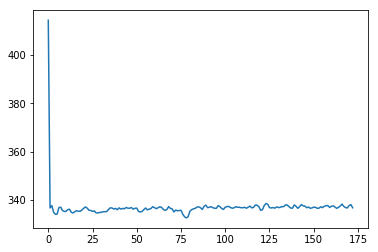

In [8]:
# Get mean over volume, for all volumes
means = np.mean(bold_data, axis=(0, 1, 2))
plt.plot(means);

We drop the first volume:

In [9]:
bold_data = bold_data[:, :, :, 1:]
bold_data.shape

(64, 64, 30, 172)

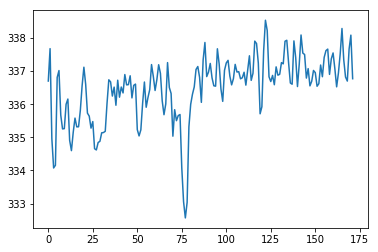

In [10]:
# Get mean over volume, for all volumes, now we dropped the first
means = np.mean(bold_data, axis=(0, 1, 2))
plt.plot(means);

The scanner acquired these data with interleaved slices in time.  That means that the scanner first acquired slice 0, then slice 2 up to slice 29, and then returned to acquire slice 1, slice 3 up to slice 29.  This type of acquisition is often called "ascending interleaved".

Let's get the data for the voxel at coordinate 43, 38, 0.  The last 0 tells us this data is from the first (bottom) slice.  Here is the voxel value at that coordinate, for the first volume (volume 0):

In [11]:
bold_data[43, 38, 0, 0]

196.0

Here is the voxel value for the same coordinate in the second volume:

In [12]:
bold_data[43, 38, 0, 1]

210.0

This is the voxel value for all volumes:

In [13]:
time_course_slice_0 = bold_data[43, 38, 0, :]
time_course_slice_0.shape

(172,)

Of course the first two values are the values we have already seen:

In [14]:
time_course_slice_0[:2]

array([ 196.,  210.])

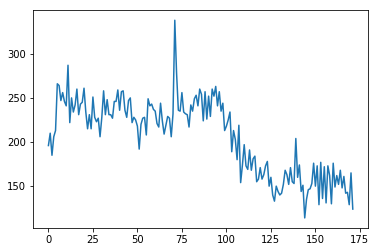

In [15]:
# Plot the time course from the voxel from slice 0
plt.plot(time_course_slice_0);

Note that the x axis is in scans.  To convert to seconds, we need to get the times for the start of each TR:

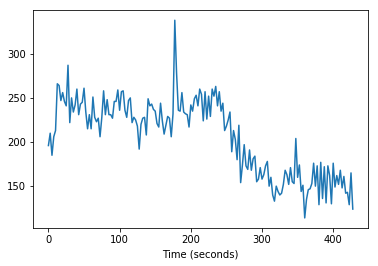

In [16]:
TR = 2.5 # time to acquire one scan
T = len(time_course_slice_0) # number of scans
times_slice_0 = np.arange(T) * TR
plt.plot(times_slice_0, time_course_slice_0)
plt.xlabel('Time (seconds)');

We can also get a time course for the equivalent voxel, but one slice up:

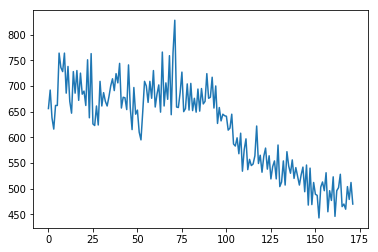

In [17]:
time_course_slice_1 = bold_data[43, 38, 1, :] # same voxel, slice 1
plt.plot(time_course_slice_1);

Notice our x axis is still in TRs (scans).  What times were these slice 1 values acquired?  They were acquired half way through the TR, after the scanner had finished acquiring all the even slices (slice 0, slice 2, ....).  So the times in seconds for these values are:

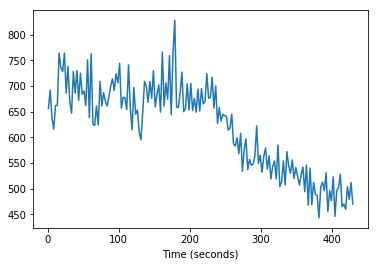

In [18]:
times_slice_1 = np.arange(T) * TR + TR / 2. # Add time offset for this slice
plt.plot(times_slice_1, time_course_slice_1)
plt.xlabel('Time (seconds)');

At the moment we can't see the offset in time between these slices; let's plot only the first eight values:

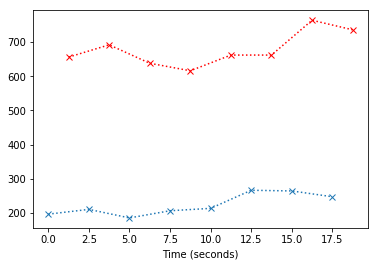

In [19]:
plt.plot(times_slice_0[:8], time_course_slice_0[:8], 'x:')
plt.plot(times_slice_1[:8], time_course_slice_1[:8], 'rx:')
plt.xlabel('Time (seconds)');

The job of slice timing, is to find new values for the red line, which correspond to the times of acquisition of the blue line (the blue crosses).  In order to do this, we can use linear interpolation.  You can think of this as drawing a vertical line at $x=t$ where $t$ is the time of acqusition of the first slice.  We then take the value from the red line where this $x=t$ line crosses the red line:

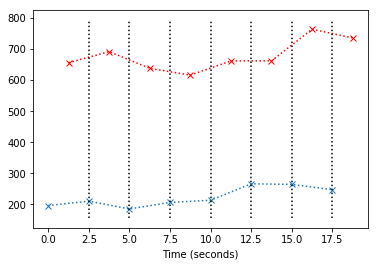

In [20]:
plt.plot(times_slice_0[:8], time_course_slice_0[:8], 'x:')
plt.plot(times_slice_1[:8], time_course_slice_1[:8], 'rx:')
ax = plt.gca()
min_y, max_y= ax.get_ylim()
for i in range(1, 8):
    x = times_slice_0[i]
    plt.plot([x, x], [min_y, max_y], 'k:')
plt.xlabel('Time (seconds)');

The value at $x$ for the straight line between any two of the points $(x_0, y_0)$ and $(x_1, y_1)$ on the red line is given by:

$$
y = y_0 + (y_1 - y_0) \frac{x_1 - x}{x_1 - x_0}
$$

You can probably convince yourself of this by drawing the line on a piece of
paper, and working out the slope and intercept.  For more information, see
<http://en.wikipedia.org/wiki/Linear_interpolation>.

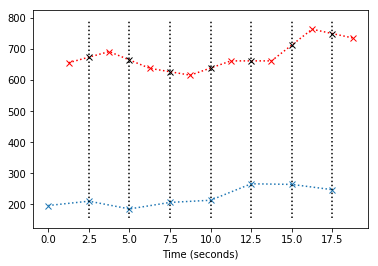

In [21]:
plt.plot(times_slice_0[:8], time_course_slice_0[:8], 'x:')
plt.plot(times_slice_1[:8], time_course_slice_1[:8], 'rx:')
ax = plt.gca()
min_y, max_y= ax.get_ylim()
for i in range(1, 8):
    x = times_slice_0[i]
    plt.plot([x, x], [min_y, max_y], 'k:')
    x0 = times_slice_1[i-1]
    x1 = times_slice_1[i]
    y0 = time_course_slice_1[i-1]
    y1 = time_course_slice_1[i]
    y = y0 + (y1 - y0) * (x1 - x) / (x1 - x0)
    plt.plot(x, y, 'kx')
plt.xlabel('Time (seconds)');

So now we can just replace the original values from the red line (values for slice 1) with our best guess values if the slice had been taken at the same times as slice 0 (the beginning of the volume):

In [22]:
est_time_course_slice_1 = np.zeros(T)
for i in range(1, T): # Don't interpolate for first value
    x = times_slice_0[i]
    x0 = times_slice_1[i-1]
    x1 = times_slice_1[i]
    y0 = time_course_slice_1[i-1]
    y1 = time_course_slice_1[i]
    y = y0 + (y1 - y0) * (x1 - x) / (x1 - x0)
    est_time_course_slice_1[i] = y
# Fill in the first value with something
est_time_course_slice_1[0] = est_time_course_slice_1[1]

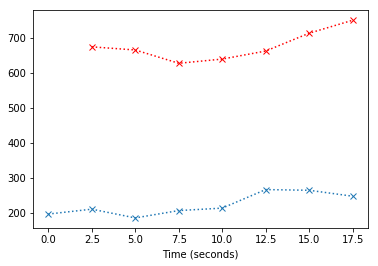

In [23]:
plt.plot(times_slice_0[:8], time_course_slice_0[:8], 'x:')
plt.plot(times_slice_0[1:8], est_time_course_slice_1[1:8], 'rx:')
plt.xlabel('Time (seconds)');

We do this for every slice except the first, and then make a new dataset containing the interpolated time courses for all slices.  Now we have done slice timing correction.